In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

*NB:* the data set is too large for github; it can be downloaded from AWS S3 [here](https://s3.amazonaws.com/shr-data/all-seasons.7z). It has also been compressed with the [7zip](http://p7zip.sourceforge.net/) program, which is also available for OS X via [Homebrew](http://brew.sh/).

In [4]:
# read in and preprocess the data
bks = pd.read_csv('all-seasons.csv')
bks['date'] = pd.to_datetime(bks['date_stamp'], yearfirst=True, errors='coerce')
bks['year'] = bks.date.apply(lambda d: d.year)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
bks = bks.join(pd.get_dummies(bks.type, prefix='type'))

The `type` column encodes the outcome of each swing, taking one of three values:

* `X` &ndash; hit
* `S` &ndash; strike
* `B` &ndash; ball


In [6]:
type_cols = ['type_S', 'type_X', 'type_B']

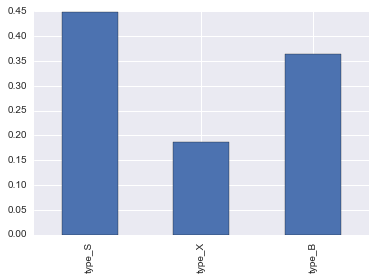

In [7]:
bks[type_cols].mean().plot(kind='bar')

In [8]:
# group by player ids to measure individual performance
batters = bks.groupby('batter_id')
pitchers = bks.groupby('pitcher_id')

There is variance in performance among players:

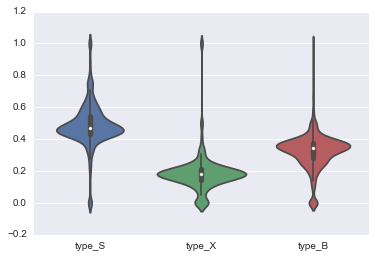

In [9]:
sb.violinplot(data=batters[type_cols].mean())

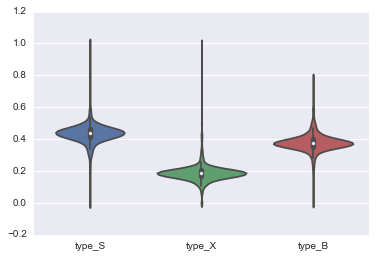

In [10]:
sb.violinplot(data=pitchers[type_cols].mean())

We can measure 'matchups' between pitchers and batters:

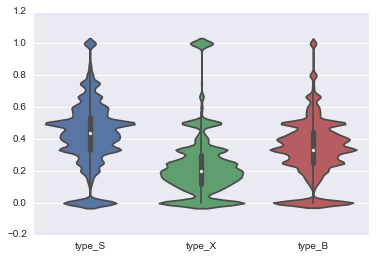

In [11]:
matchups = bks.groupby(['batter_id', 'pitcher_id'])
sb.violinplot(data=matchups[type_cols].mean())

To reduce noice and the effect of individual player skill, we can use only the results of interactions between players that have faced each other many times.

In [12]:
matchups.size().describe()

count    296351.000000
mean         13.732371
std          16.796943
min           1.000000
25%           5.000000
50%           8.000000
75%          16.000000
max         325.000000
dtype: float64

Since the mean is roughly 13 and the standard deviation is roughly 16, we'll use 30 as the minimum threshold.

In [13]:
over_30 = matchups.filter(lambda g: len(g) >= 30)

Each pitch is counted as one of roughly 18 pitch types. The PITCHf/x software that generates the data uses a neural net classification algorigthm<sup>[1](https://fastballs.wordpress.com/2007/08/02/glossary-of-the-gameday-pitch-fields/)</sup> to classify pitches; Brooks Baseball (the source of this data), hand-corrects pitch types and related data<sup>[2](http://www.brooksbaseball.net/about.php)</sup>.

Not all pitches should be considered, as some pitch types represent intentionally or unintentionally wild pitches and other invalid results, or aren't common enough in the data set to draw valid conclusions about.

In [14]:
over_30 = over_30.join(pd.get_dummies(over_30.mlbam_pitch_name, prefix='pitch_name'))
pt_cols = [c for c in over_30.columns if c[:10] == 'pitch_name']

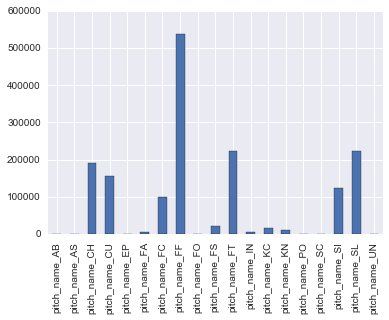

In [15]:
over_30[pt_cols].sum().plot(kind='bar')

In [16]:
valid_pts = ['CH', 'CU', 'FC', 'FF', 'FT', 'SI', 'SL']

In [17]:
over_30_valid = over_30[over_30.mlbam_pitch_name.isin(valid_pts)]
valid_pt_cols = ['pitch_name_{}'.format(pt) for pt in valid_pts]

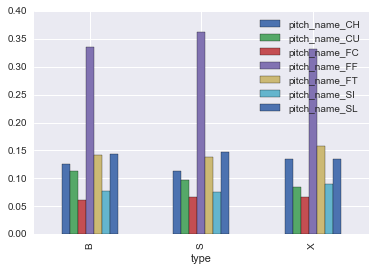

In [18]:
over_30_valid.groupby('type')[valid_pt_cols].mean().plot(kind='bar')

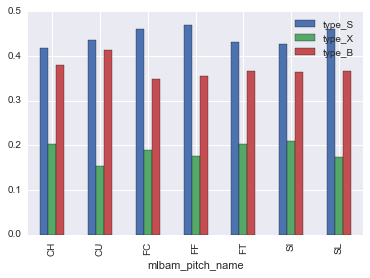

In [19]:
over_30_valid.groupby('mlbam_pitch_name')[type_cols].mean().plot(kind='bar')

As we can see, different types of pitches result in different proportions of outcomes.

We can also investigate other factors. Handedness, for example, is encoded in the data in the `stand` column for batters, and the `p_throws` column for pitchers.

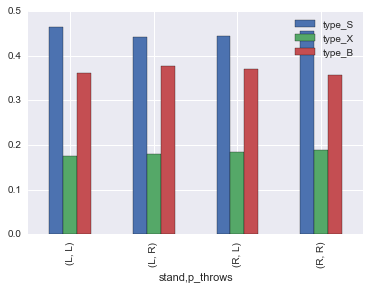

In [20]:
over_30_valid.groupby(['stand', 'p_throws'])[type_cols].mean().plot(kind='bar')

We can measure the effect of time.

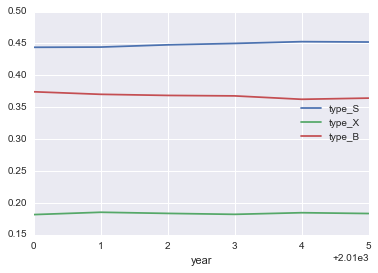

In [27]:
over_30_valid.groupby('year')[type_cols].mean().plot()

Another potential factor is where in the strike zone a pitch crossed home plate, encoded in the data in the `zone_location` column.

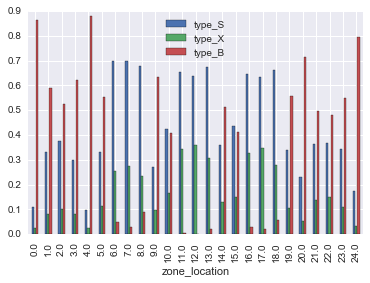

In [21]:
over_30_valid.groupby('zone_location')[type_cols].mean().plot(kind='bar')

Further research will be necessary to determine the statistical significance of these factors.